In [1]:
import pandas as pd
import numpy as np
import baltic as bt
from scipy import stats
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.5, palette='Paired')

In [2]:
######  CONFIG; EDIT ME  #####

# Pull pre-computed clade frequencies
frequency_path = '../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

# these are identical trees, but with `dTiter` values assigned by the titer model either to 
# all/any branch in the tree, or restricted to branches between serotypes
all_branch_effects_tree = '../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json' 
interserotype_branch_effects_tree = '../../data/titer-model/interserotype-branch-effects/jsons/dengue_all_tree.json'

# the node IDs ("clade" trait from augur) of the MRCAs of 
# all antigenically uniform clades (as determined by cTiter values in the all branch effects tree)
uniform_cTiter_clades = [str(i) for i in [4, 33, 117, 495, 975, 980, 996, 1017, 1020, 1033, 1089, 
                         1386, 1395, 1454, 1588, 1594, 1860, 2027, 2037, 2119, 
                         2167, 2173, 2185, 2230, 2238, 2588] ]

serotype_clades = [str(i) for i in [1859,1,1385,974] ] # serotype MRCAs
genotype_clades = [str(i) for i in [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638] ] # canonical genotype MRCAs

date_range = (1970., 2015.) # informative date range
years_back = 3 # how many years before the season of interest to look at past circulation
years_forward = 5 # how many years in the future to predict

sigma = -0.15
gamma = -0.25

In [6]:
##### Input and setup #####

def normalize_frequencies_by_timepoint(frequencies):
    ''' Normalize each row so that the sum of all frequencies at a single timepoint = 1'''
    def normalize(row):
        total = row.sum()
        if np.isnan(total) or total == 0:
            return row
        else:
            return row.map( lambda x: x / total)
    
    if isinstance(frequencies, dict):
        frequencies = pd.DataFrame(frequencies)
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies.to_dict()

    else:
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies

all_frequencies = pd.read_csv(frequency_path, index_col=0)
all_frequencies = normalize_frequencies_by_timepoint(all_frequencies[genotype_clades]) # normalize the actual frequencies
all_frequencies = all_frequencies.loc[(all_frequencies.index >= date_range[0]) & (all_frequencies.index <= date_range[1])]

In [7]:
timepoints = all_frequencies.index.tolist()
n_years = int(timepoints[-1]) - int(timepoints[0]) # number of years in the frequencies dataset
tppy = int(len(timepoints)/n_years) # timepoints per year

tp_back = years_back*tppy # number of timepoints to sum over
tp_forward = years_forward*tppy # number of timepoints forward to predict

## Load both trees from JSON
all_branch_effects_tree = bt.loadJSON(all_branch_effects_tree, json_translation={'name': 'strain', 'height': 'xvalue'})
interserotype_branch_effects_tree = bt.loadJSON(interserotype_branch_effects_tree, json_translation = {'name': 'strain', 'height': 'xvalue'})

## { clade_ID_number: bt.node object }
all_branch_effects_clade_lookup = {str(k.traits['clade']) : k for k in all_branch_effects_tree.Objects}
interserotype_branch_effects_clade_lookup = {str(k.traits['clade']):k for k in interserotype_branch_effects_tree.Objects}

## check the trees are identical and copy the interserotype_dTiter values 
## so we can access both models' estimates in the same structure
for clade, k in all_branch_effects_clade_lookup.items():
    compare = interserotype_branch_effects_clade_lookup[clade]
    assert k.traits['strain'] == compare.traits['strain']
    
    k.traits['interserotype_dTiter'] = compare.traits['dTiter']
    
clade_lookup = all_branch_effects_clade_lookup # This tree now contains both dTiter measurements for each branch
titer_tree = all_branch_effects_tree


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [8]:
##### Calculate antigenic distance #####

precomputed_titers = defaultdict(dict) 

def are_homotypic(clade1, clade2, clade_lookup=clade_lookup):
    k1, k2 = clade_lookup[clade1], clade_lookup[clade2]
    sero1, sero2 = k1.traits['strain'].split('_')[0], k2.traits['strain'].split('_')[0]
    return sero1==sero2
        
def get_dTiter(clade1, clade2, antigenic_resolution, clade_lookup=clade_lookup):
    '''Calculates dTiter under several different models, indicated as antigenic_resolution arg.
    * 'serotype': sum dTiter on each branch of the interserotype-only tree between clade1 and clade 2
    * 'genotype': sum dTiter on each branch of the all-branch-effects tree between clade1 and clade 2
    * 'null': all strains are antigenically uniform, return 0.
    '''
    
    clades = tuple(sorted([clade1, clade2])) # sorted to avoid key errors
     
    try:
        return precomputed_titers[antigenic_resolution][clades]
    except KeyError:
        pass
        
    if antigenic_resolution == 'serotype':
        tree_trait = 'interserotype_dTiter'
    elif antigenic_resolution == 'clade':
        tree_trait = 'dTiter'
    else:
        raise AssertionError, "ERROR: Valid antigenic resolutions are ['serotype', 'clade']. Got: ", antigenic_resolution
        
    k1, k2 = clade_lookup[clade1], clade_lookup[clade2] # pull bt node objects from the tree
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    dTiter = sum([k.traits[tree_trait] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2
    precomputed_titers[antigenic_resolution][clades] = dTiter # save for later
    
    return dTiter

In [9]:
###### Calculate antigenic fitness #######

def waning(gamma, n):
    ''' Assume immunity wanes linearly with slope gamma per year (n)'''
    return max(gamma*n + 1., 0.)

def probability_protection(sigma, titer):
    ''' Assume the probability of protection is linearly related to titers with slope sigma '''
    return max(sigma*titer + 1., 0.)

def sum_over_j(i, timepoint, proportion_remaining, cocirculating_clades, antigenic_resolution, frequencies, sigma=sigma):
    ''' 
    Look at all a single time point. 
    At that timepoint, look at all clades, j, that are cocirculating with i.
    Pull the titers between i and j (D_ij) and adjust for waning immunity (proportion_remaining). 
    Use this to calculate a frequency-weighted estimate sum of the probability of protection against i given prior exposure to j.
    '''
    
    frequency_weighted_protection = 0.
    
    for j in cocirculating_clades:
        titers = get_dTiter(i, j, antigenic_resolution)       
        remaining_titers = proportion_remaining * titers
        probability_protected = probability_protection(sigma, remaining_titers)
        j_frequency = frequencies[j][timepoint]
        
        frequency_weighted_protection += probability_protected*j_frequency
        
    return frequency_weighted_protection


def sum_over_past_t(i, timepoint_of_interest, cocirculating_clades, frequencies, antigenic_resolution, 
               timepoints=timepoints, tp_back=tp_back, sigma=sigma, gamma=gamma):
    ''' 
    For a given time point of interest, look at what the population has acquired protection to
    over the past `tp_back` timepoints. 
    For each previous timepoint, sum_over_j to calculate the accumulated immunity.
    '''
    
    tp_idx = timepoints.index(timepoint_of_interest) # index of timepoint of interest
    t_to_sum = timepoints[tp_idx - tp_back : tp_idx] # previous timepoints to sum immunity over
    
    # proportion of titers acquired in each interval expected to remain by timepoint of interest 
    waning_over_time = [ waning(gamma, t - timepoint_of_interest) for t in t_to_sum] 
    
    # proportion of the population that acquired protection in each interval
    protection_over_time = [ sum_over_j(i, t, p_remaining, cocirculating_clades, 
                                      antigenic_resolution, frequencies, sigma) 
                          for (t, p_remaining) in zip(t_to_sum, waning_over_time) ]

    accumulated_protection = sum(protection_over_time)/float(len(protection_over_time))
    return accumulated_protection

def calculate_fitness(i, cocirculating_clades, frequencies, antigenic_resolution, 
               timepoints=timepoints, tp_back=tp_back,
               sigma=sigma, gamma=gamma):
    ''' f = 1. - P
        where P is the proportion of the population that is immune to i at the beginning of season t
    '''
    
    valid_timepoints = timepoints[tp_back:]
    
    if antigenic_resolution == 'null':
        return { t: 0. for t in valid_timepoints }
    else:
        population_exposure = { t: sum_over_past_t(i, t, cocirculating_clades, frequencies, antigenic_resolution) for t in valid_timepoints}
        fitness = { t: 1. - P for t,P in population_exposure.iteritems()}
    
    return fitness

In [10]:
null_fitness = pd.DataFrame({ i: calculate_fitness(i, genotype_clades,all_frequencies, 'null') for i in genotype_clades})
clade_fitness = pd.DataFrame({i: calculate_fitness(i, genotype_clades, all_frequencies, 'clade') for i in genotype_clades})


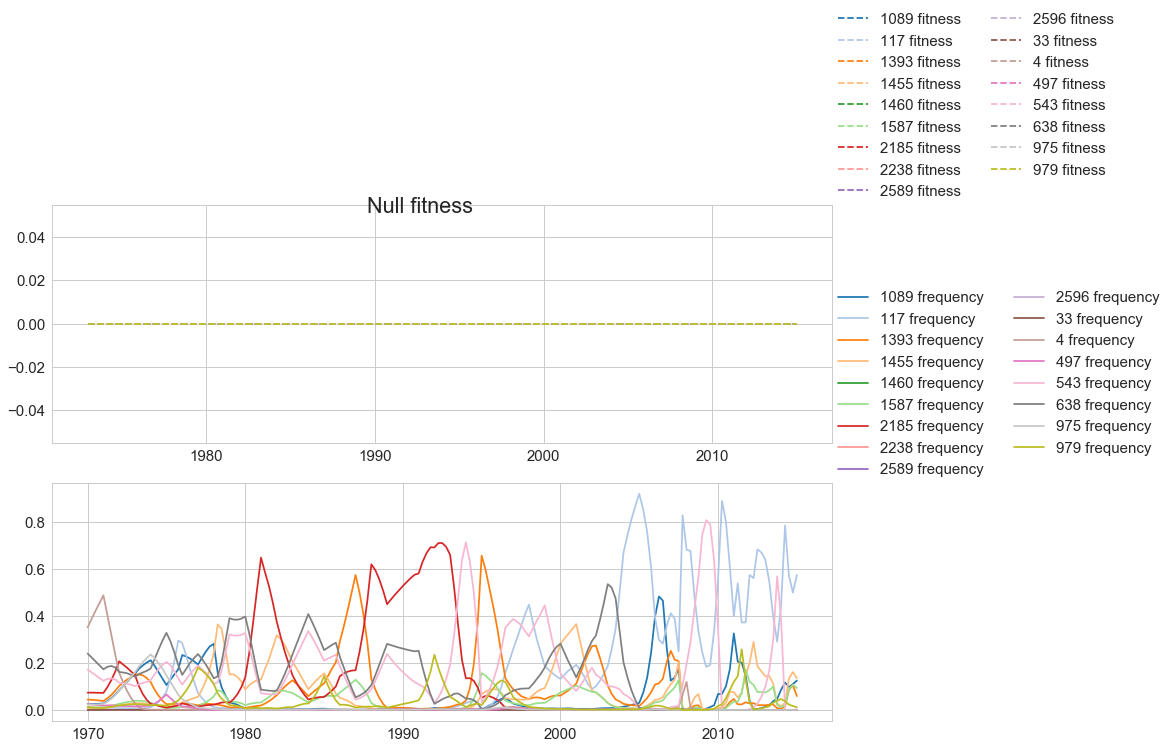

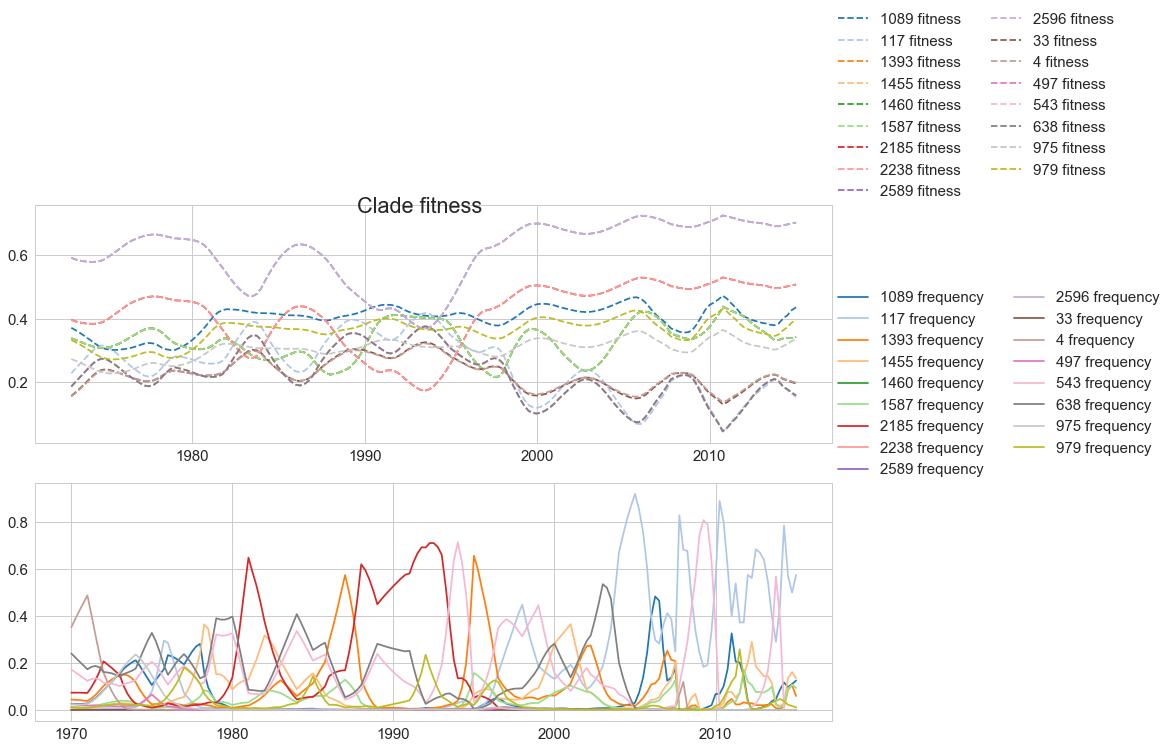

In [15]:
def plot_fitness_v_frequency(fitness, all_frequencies, title=None):
    sns.set_palette('tab20', n_colors=20)
    
    fig, axes = plt.subplots(2,1,figsize=(12,8))

    for clade in fitness.columns.values:
        axes[0].plot(fitness[clade].index.values, fitness[clade], linestyle='--', label='%s fitness'%clade)
        axes[1].plot(all_frequencies[clade].index.values, all_frequencies[clade], linestyle='-', label='%s frequency'%clade)
    
    plt.sca(axes[0])
    plt.legend(loc=(1,1), ncol=2)
    plt.sca(axes[1])
    plt.legend(loc=(1,1), ncol=2)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plot_fitness_v_frequency(null_fitness, all_frequencies, title='Null fitness')
plot_fitness_v_frequency(clade_fitness, all_frequencies, title='Clade fitness')

In [16]:
print all_frequencies.head()

             2185  2589  2238  2596  1460      1393      1587      1455  \
1970.00  0.073461   0.0   0.0   0.0   0.0  0.044344  0.011487  0.008548   
1970.25  0.073614   0.0   0.0   0.0   0.0  0.043287  0.011222  0.008283   
1970.50  0.073431   0.0   0.0   0.0   0.0  0.041923  0.010814  0.008011   
1970.75  0.072713   0.0   0.0   0.0   0.0  0.040085  0.010388  0.007724   
1971.00  0.072350   0.0   0.0   0.0   0.0  0.038303  0.009975  0.007315   

              975       979      1089        33       497       117       543  \
1970.00  0.023641  0.012021  0.026446  0.000134  0.025644  0.011620  0.171898   
1970.25  0.023113  0.010688  0.025518  0.000134  0.023914  0.010822  0.159786   
1970.50  0.023231  0.009880  0.025501  0.000134  0.022029  0.010013  0.147797   
1970.75  0.024238  0.009455  0.026368  0.000133  0.020242  0.009189  0.135837   
1971.00  0.025535  0.009044  0.027530  0.000133  0.018487  0.008379  0.123820   

                4       638  
1970.00  0.351008  0.239749  
19